# [CDAF] Atividade 2

## Nome: Thiago Pádua de Carvalho

## Matrícula: 2020007066

## Introdução
Nesta atividade, vamos revisar os conceitos aprendidos em sala de aula sobre estatísticas agregadas. Para esta atividade, usaremos dados do Brasileirão 2022 do FBRef.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# opening data
import warnings

# used for plots
from mplsoccer import FontManager, Radar, FontManager
import random

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Questão 1
- Baixe o dataset de resultados em https://fbref.com/en/comps/24/2022/schedule/2022-Serie-A-Scores-and-Fixtures
- Crie uma média móvel de 5 jogos, para cada equipe, de cada uma das seguintes estatísticas: xg_pro pró, xg_pro contra, e dif. xg_pro.
- Escolha 4 times para visualizar a série temporal das estatísticas acima. Uma visualização para cada uma das estatísticas, onde a média geral do campeonato é apresentada com uma linha pontilhada em conjunto com a média móvel dos times escolhidos.
- Interprete os resultados. O que isso pode indicar sobre a qualidade ofensiva e defensiva dos times escolhidos?

In [43]:
BRA1 = pd.read_csv('data/brazilian_league_20222.csv', sep=',')
BRA1.drop(columns=['Match Report', 'Notes', 'Attendance', 'Venue', 'Time', 'Referee', 'Day'], inplace=True)
BRA1 = BRA1.dropna()
BRA1 = BRA1.rename(columns={'xG':'xg_pro', 'xG.1':'xg_con'})
display(BRA1)

,Wk,Date,Home,xg_pro,Score,xg_con,Away
0,1.0,2022-04-09,Fluminense,1.6,0–0,0.1,Santos
1,1.0,2022-04-09,Atl Goianiense,1.4,1–1,1.2,Flamengo
2,1.0,2022-04-10,Coritiba,1.7,3–0,0.4,Goiás
3,1.0,2022-04-10,Atlético Mineiro,1.9,2–0,0.6,Internacional
4,1.0,2022-04-10,Botafogo (RJ),1.5,1–3,2.1,Corinthians
...,...,...,...,...,...,...,...
417,38.0,2022-11-13,Bragantino,0.9,0–1,0.6,Fluminense
418,38.0,2022-11-13,América (MG),2.1,1–1,0.5,Atl Goianiense
419,38.0,2022-11-13,Goiás,0.2,0–4,1.7,São Paulo
420,38.0,2022-11-13,Internacional,1.4,3–0,1.3,Palmeiras


In [44]:
def assign_xg(match, home=True):
    if home:
        xg_pro = match['xg_pro']
        xg_con = match['xg_con']
    else:
        xg_pro = match['xg_con']
        xg_con = match['xg_pro']
    return xg_pro, xg_con, xg_pro - xg_con

In [45]:
def rolling_average(teams, window):
    teams_dataframe = {}
    for team in teams:
        team_df = pd.DataFrame(columns=['xg_pro', 'xg_con', 'xg_diff', 'Game'])
        matches = BRA1.loc[(BRA1['Home'] == team) | (BRA1['Away'] == team)]
        game = 0
        for i, match in matches.iterrows():
            game += 1
            if match['Home'] == team:
                xg_pro, xg_con, xg_diff = assign_xg(match)
            else:
                xg_pro, xg_con, xg_diff = assign_xg(match, home=False)
            
            team_df.at[i, "xg_pro"] = xg_pro
            team_df.at[i, "xg_con"] = xg_con
            team_df.at[i, "xg_diff"] = xg_diff
            team_df.at[i, "Game"] = game

        team_df['xg_pro_RA'] = team_df['xg_pro'].rolling(window=window, win_type='triang', min_periods=1).mean()
        team_df['xg_con_RA'] = team_df['xg_con'].rolling(window=window, win_type='triang', min_periods=1).mean()
        team_df['xg_diff_RA'] = team_df['xg_diff'].rolling(window=window, win_type='triang', min_periods=1).mean()

        teams_dataframe[team] = team_df
    
    return teams_dataframe

In [46]:
def get_mean_statistic(statistic: str, league_dataframe: pd.DataFrame):
    rounds_df = pd.DataFrame(columns=['statistical_value'])
    new_statistic = {}
    for i in range(1, 39):
        if statistic != 'xg_diff':
            new_statistic[i] = league_dataframe.loc[(league_dataframe['Wk'] == i), statistic]
        else:
            xg_pro = league_dataframe.loc[(league_dataframe['Wk'] == i), 'xg_pro']
            xg_con = league_dataframe.loc[(league_dataframe['Wk'] == i), 'xg_con']
            new_statistic[i] = xg_pro - xg_con
        rounds_df.at[i, 'statistical_value'] = new_statistic[i].mean()

    return rounds_df

In [47]:
def plot_RA(league, team_dfs, statistic, teams_to_plot, window):
    fig, ax = plt.subplots(figsize=(8, 4))
    
    df_mean_statistic = get_mean_statistic(statistic, league)
    ax.plot(df_mean_statistic.index, df_mean_statistic['statistical_value'].rolling(window=window, win_type='triang', min_periods=1).mean(),
             linewidth=3, linestyle='dashed',color='black', alpha = 1, zorder = 2, label = 'Média Geral')

    colors = ['green', 'red', 'blue', 'purple']
    alphas = [1, 1, 1, 1]

    for club, color, alpha in zip(teams_to_plot, colors, alphas):
        ax.plot(team_dfs[club]['Game'],  team_dfs[club][f'{statistic}_RA'], linewidth=2, linestyle='-',color=color, alpha = alpha, zorder = 2, label = club)

    ax.set_title(f"{statistic} {window} rounds Moving Average  - Brazilian League 2022", fontsize = 18, pad=20)  # set title
    ax.set_xticklabels([])  # no text
    ax.set_xticks(np.arange(1, 39))
    ax.tick_params(axis='x', color='white', which='both', labelsize = 20)  # disable black ticks, but big text xaxis
    ax.tick_params(axis='y', color='grey', labelsize = 14)  # grey y ticks
    ax.grid(zorder = 1, linestyle = "--", alpha = 0.5)  # add grid
    
    # disable spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    #add axis labels
    ax.set_ylabel(f"{statistic} Moving Average per game", fontsize=16, labelpad=10)
    ax.set_xlabel('Round', fontsize=18, labelpad=10)
    plt.legend(bbox_to_anchor=(1.0, 0.5), loc="center left", fontsize=12, edgecolor='white')  # make legend
    plt.show()

In [48]:
def RA_calc_and_plot(league: pd.DataFrame, teams_to_plot: list, window: int=5):
    statistics = ['xg_pro', 'xg_con', 'xg_diff']
    teams = league['Home'].unique()
    teams_df = rolling_average(teams, window=window)
    for statistic in statistics:
        plot_RA(league, teams_df, statistic, teams_to_plot, window)

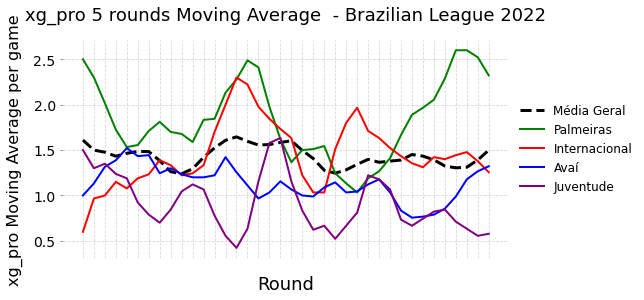

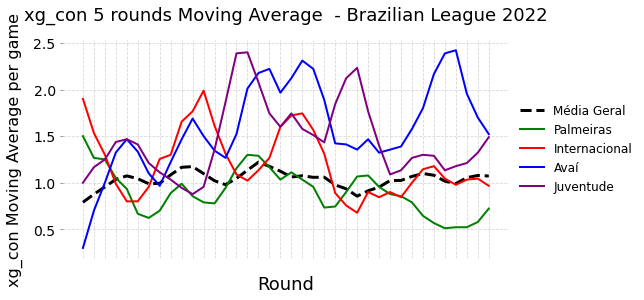

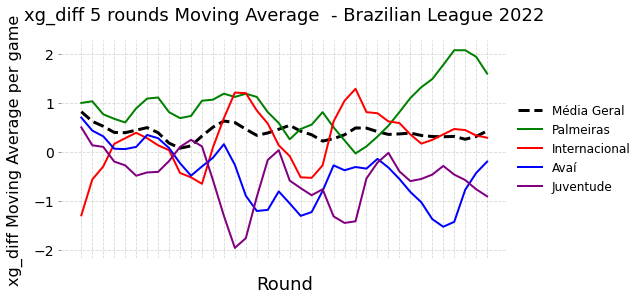

In [49]:
RA_calc_and_plot(BRA1, ['Palmeiras', 'Internacional', 'Avaí', 'Juventude'])

### Avaliando resultados:
Os times escolhidos foram Palmeiras, Internacional, Avaí e Juventude. Respectivamente, o primeiro, segundo, penúltimo e último colocados no Campeonato Brasileiro de 2022.
Plotados os gráficos com Gols Esperados a favor, Gols Esperados Contra e diferença de gols esperados para cada time, pode-se que a equipe paulista teve um grande destaque sobre o todo, mostrando superioridade considerável até ao segundo colocado durante quase a totalidade do campeonato, em qualquer quesito apresentado.

De mogo geral, as equipes do topo da tabela se mostram acima ou próximas da média de gols esperados durante a maioria do campeonato, de onde conclui-se que possuem boa ofensividade. O Internacional possui ocilações nesse sentido, mostrando que o time não manteve constância de ataque durante o campeonato. Os dois times lanternas, por outro lado, se mantiveram abaixo da média de gols esperados durante todo o campeonato, evidenciando um ataque pouco efetivo.

No quesito Gols Esperados Contra, o Palmeiras se destaca novamente, mantendo sua média sempre baixa. As outras equipes oscilam bastante e especialmente Juventude e Avaí se mantêm acima da média.

Juntando ambos os quesitos, podemos chegar na diferença de gols esperados, que basicamente diz se é esperado que o time perca ou vença. Os dois últimos colocados têm, salvo poucas exceções, sua diferença de gols negativa durante todo o campeonato. O Palmeiras tem somente índices não negativos e o Internacional oscila, podendo indicar que teve baixos durante a competição.

https://soccermatics.readthedocs.io/en/latest/gallery/lesson5/plot_PointsMovingAverage.html#points-moving-average

## Questão 2
- Agora repita a questão 1, plotando as séries temporais dos mesmos times, mas para uma janela móvel de 10 jogos.
- Quais as diferenças entre as séries temporais de 5 e 10 jogos? Em quais situações pode ser vantajoso escolher uma janela à outra?

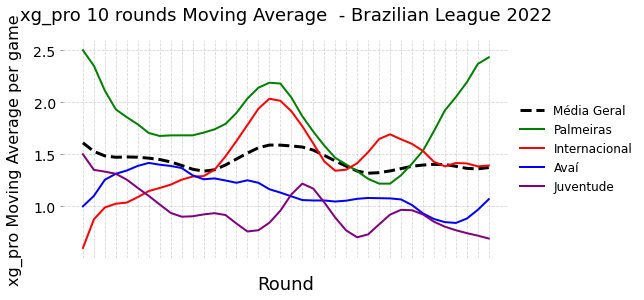

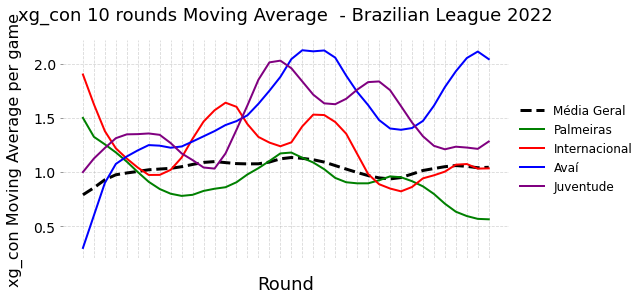

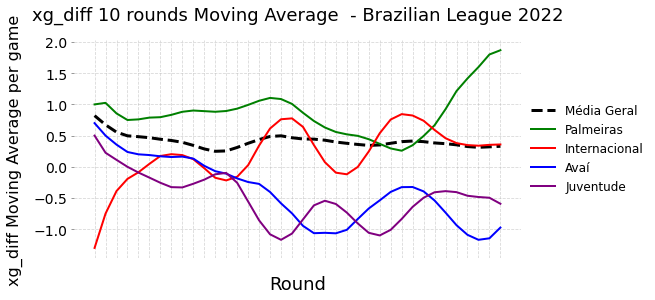

In [50]:
RA_calc_and_plot(BRA1, ['Palmeiras', 'Internacional', 'Avaí', 'Juventude'], window=10)

### Avaliando Resultados
Como esperado, de acordo com a escolha da média móvel, o uso de uma janela maior de rodadas suaviza a série de dados e, consequentemente, as curvas dos times, uma vez que o prazo maior reduz a observação de variações repentinas. Isso, contudo, não altera as tendências observadas.

É mais vantajoso aumentar a janela da média móvel quando deseja-se observar os dados em longo prazo, suavizando os dados para observar tendências com período grande.

## Questão 3
- Vá para o link
-- https://fbref.com/en/comps/24/2022/stats/2022-Serie-A-Stats
- Nesta seção de estatísticas, é possível navegar por estatísticas específicas para diferentes aspectos do jogo (finalização, passe, defesa, etc.). Para todos exercícios à partir deste, você terá que selecionar aquelas que julgar mais relevantes para responder as questões.
- Monte um radar plot com 6 atributos relevantes para atacantes e compare 3 jogadores de sua escolha. Justifique a escolha de cada um dos atributos, a escolha da escala dos radares e o tipo de normalização. Interprete os resultados dos radares em termos das qualidades e limitações dos jogadores.
- Ref Soccermatics:
-- https://soccermatics.readthedocs.io/en/latest/lesson3/ScoutingPlayers.html
-- https://soccermatics.readthedocs.io/en/latest/gallery/lesson3/plot_RadarPlot.html

In [51]:
# Loading and cleaning Data
shooting = pd.read_csv('data/player_data_BRA1_2022/player_shooting.csv', sep=',')
shooting.set_index('Rk',inplace=True)
shooting.drop(inplace=True, columns={'Matches','-9999','Age', 'Nation', 'FK', 'PK', 'PKatt'})
display(shooting.head(2))
print(shooting.columns)

,Player,Pos,Squad,Born,90s,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,xG,npxG,npxG/Sh,G-xG,np:G-xG
Rk,,,,,,,,,,,,,,,,,,,
1,Abner,DF,Atl Paranaense,2000,23.4,1,13,3,23.1,0.56,0.13,0.08,0.33,21.0,1.2,1.2,0.09,-0.2,-0.2
2,Adryelson,DF,Botafogo (RJ),1998,16.1,0,15,4,26.7,0.93,0.25,0.00,0.00,10.9,1.2,1.2,0.08,-1.2,-1.2


Index(['Player', 'Pos', 'Squad', 'Born', '90s', 'Gls', 'Sh', 'SoT', 'SoT%',
       'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT', 'Dist', 'xG', 'npxG', 'npxG/Sh',
       'G-xG', 'np:G-xG'],
      dtype='object')


In [52]:
# Loading and cleaning Data
passing = pd.read_csv('data/player_data_BRA1_2022/player_passing.csv', sep=',')
passing.set_index('Rk',inplace=True)
passing.drop(inplace=True, columns={'Matches', 'Nation', 'Age','-9999'})
display(passing.head(2))
print(passing.columns)

,Player,Pos,Squad,Born,90s,Cmp_total,Att_total,Cmp%_total,TotDist,PrgDist,...,Cmp%_long,Ast,xAG,xA,A-xAG,KP,1/3,PPA,CrsPA,PrgP
Rk,,,,,,,,,,,,,,,,,,,,,
1,Abner,DF,Atl Paranaense,2000,23.4,986.0,1283.0,76.9,17089.0,6919.0,...,50.3,2,2.2,1.7,-0.2,31.0,105.0,16.0,6.0,139.0
2,Adryelson,DF,Botafogo (RJ),1998,16.1,540.0,662.0,81.6,10461.0,4038.0,...,60.2,0,0.3,0.1,-0.3,3.0,15.0,0.0,0.0,20.0


Index(['Player', 'Pos', 'Squad', 'Born', '90s', 'Cmp_total', 'Att_total',
       'Cmp%_total', 'TotDist', 'PrgDist', 'Cmp_short', 'Att_short',
       'Cmp%_short', 'Cmp_medium', 'Att_medium', 'Cmp%_medium', 'Cmp_long',
       'Att_long', 'Cmp%_long', 'Ast', 'xAG', 'xA', 'A-xAG', 'KP', '1/3',
       'PPA', 'CrsPA', 'PrgP'],
      dtype='object')


In [53]:
# Loading and cleaning Data
possession = pd.read_csv('data/player_data_BRA1_2022/player_possession.csv', sep=',')
possession.set_index('Rk',inplace=True)
possession.drop(inplace=True, columns={'Matches', 'Nation', 'Age','-9999'})
display(possession.head(2))
print(possession.columns)

,Player,Pos,Squad,Born,90s,Touches,Def Pen,Def 3rd,Mid 3rd,Att 3rd,...,Carries,TotDist,PrgDist,PrgC,1/3,CPA,Mis,Dis,Rec,PrgR
Rk,,,,,,,,,,,,,,,,,,,,,
1,Abner,DF,Atl Paranaense,2000,23.4,1480.0,84.0,432.0,737.0,321.0,...,717.0,3076.0,1620.0,29.0,25.0,5.0,17.0,12.0,812.0,68.0
2,Adryelson,DF,Botafogo (RJ),1998,16.1,857.0,141.0,489.0,335.0,36.0,...,410.0,1884.0,827.0,3.0,1.0,1.0,6.0,0.0,462.0,2.0


Index(['Player', 'Pos', 'Squad', 'Born', '90s', 'Touches', 'Def Pen',
       'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Live', 'Att', 'Succ',
       'Succ%', 'Tkld', 'Tkld%', 'Carries', 'TotDist', 'PrgDist', 'PrgC',
       '1/3', 'CPA', 'Mis', 'Dis', 'Rec', 'PrgR'],
      dtype='object')


In [54]:
defensive = pd.read_csv('data/player_data_BRA1_2022/player_defensive.csv', sep=',')
defensive.set_index('Rk',inplace=True)
defensive.drop(inplace=True, columns={'Matches', 'Nation', 'Age','-9999', 'Err'})
display(defensive.head(2))
print(defensive.columns)

,Player,Pos,Squad,Born,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,Tkl.1,Att,Tkl%,Lost,Blocks,Sh,Pass,Int,Tkl+Int,Clr
Rk,,,,,,,,,,,,,,,,,,,,
1,Abner,DF,Atl Paranaense,2000,23.4,43.0,28,26.0,14.0,3.0,24.0,38.0,63.2,14.0,18.0,3.0,15.0,39,82.0,54.0
2,Adryelson,DF,Botafogo (RJ),1998,16.1,17.0,12,14.0,3.0,0.0,8.0,10.0,80.0,2.0,18.0,12.0,6.0,22,39.0,99.0


Index(['Player', 'Pos', 'Squad', 'Born', '90s', 'Tkl', 'TklW', 'Def 3rd',
       'Mid 3rd', 'Att 3rd', 'Tkl.1', 'Att', 'Tkl%', 'Lost', 'Blocks', 'Sh',
       'Pass', 'Int', 'Tkl+Int', 'Clr'],
      dtype='object')


In [55]:
miscellaneous = pd.read_csv('data/player_data_BRA1_2022/player_miscellaneous.csv', sep=',')
miscellaneous.set_index('Rk',inplace=True)
miscellaneous.drop(inplace=True, columns={'Matches', 'Nation', 'Age','-9999'})
display(miscellaneous.head(2))
print(miscellaneous.columns)

,Player,Pos,Squad,Born,90s,CrdY,CrdR,2CrdY,Fls,Fld,...,Crs,Int,TklW,PKwon,PKcon,OG,Recov,Won,Lost,Won%
Rk,,,,,,,,,,,,,,,,,,,,,
1,Abner,DF,Atl Paranaense,2000,23.4,6,0,0,26,12,...,49,39,28,0.0,0.0,0,149.0,21.0,28.0,42.9
2,Adryelson,DF,Botafogo (RJ),1998,16.1,1,0,0,10,4,...,0,22,12,0.0,0.0,1,56.0,76.0,34.0,69.1


Index(['Player', 'Pos', 'Squad', 'Born', '90s', 'CrdY', 'CrdR', '2CrdY', 'Fls',
       'Fld', 'Off', 'Crs', 'Int', 'TklW', 'PKwon', 'PKcon', 'OG', 'Recov',
       'Won', 'Lost', 'Won%'],
      dtype='object')


In [56]:
def color_generator(number_of_colors):
    # generates a list of random colors
    colors = []
    for _ in range(number_of_colors):
        r = random.random()
        g = random.random()
        b = random.random()
        colors.append((r, g, b))

    return colors

In [57]:
# parameter names of the statistics we want to show

# The lower and upper boundaries for the statistics

# Add anything to this list where having a lower number is better
# this flips the statistic
lower_is_better = ['Miscontrol']

URL1 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-Regular.ttf')
serif_regular = FontManager(URL1)
URL2 = ('https://raw.githubusercontent.com/googlefonts/SourceSerifProGFVersion/main/fonts/'
        'SourceSerifPro-ExtraLight.ttf')
serif_extra_light = FontManager(URL2)
URL3 = ('https://raw.githubusercontent.com/google/fonts/main/ofl/rubikmonoone/'
        'RubikMonoOne-Regular.ttf')
rubik_regular = FontManager(URL3)
URL4 = 'https://raw.githubusercontent.com/googlefonts/roboto/main/src/hinted/Roboto-Thin.ttf'
robotto_thin = FontManager(URL4)
URL5 = ('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
        'RobotoSlab%5Bwght%5D.ttf')
robotto_bold = FontManager(URL5)

In [58]:
def plot_radar(params, players, low, high, lower_is_better=[]):
        radar = Radar(params, low, high,
              lower_is_better=lower_is_better,
              # whether to round any of the labels to integers instead of decimal places
              round_int=[False]*len(params),
              num_rings=4,  # the number of concentric circles (excluding center circle)
              # if the ring_width is more than the center_circle_radius then
              # the center circle radius will be wider than the width of the concentric circles
              ring_width=1, center_circle_radius=1)

        colors = color_generator(len(players))

        fig, ax = radar.setup_axis()
        rings_inner = radar.draw_circles(ax=ax, facecolor='#ffb2b2', edgecolor='#fc5f5f')

        for i, player in enumerate(players):
                player_values = player.get_data()
                player_name = player.get_name()
                radar1, vertices1 = radar.draw_radar_solid(player_values, ax=ax,
                                                        kwargs={'facecolor': colors[i],
                                                                'alpha': 0.5,
                                                                'edgecolor': '#216352',
                                                                'lw': 3})

                scatter = ax.scatter(vertices1[:, 0], vertices1[:, 1],
                        c=colors[i], edgecolors='#502a54', marker='o', s=150, zorder=2, label=player_name) 
        plt.legend(bbox_to_anchor=(1.0, 0.5), loc="center left", fontsize=12, edgecolor='white')  # make legend

        range_labels = radar.draw_range_labels(ax=ax, fontsize=25, fontproperties=robotto_thin.prop)
        param_labels = radar.draw_param_labels(ax=ax, fontsize=25, fontproperties=robotto_thin.prop)

In [59]:
class Player:
    def __init__(self, name, pos) -> None:
        self.name = name
        self.pos = pos
        self.params = []
        if self.pos == 'fw':
            self.params.append(float(shooting.loc[(shooting['Player'] == self.name), 'Gls']))
            self.params.append(float(shooting.loc[(shooting['Player'] == self.name), 'npxG']))
            self.params.append(float(shooting.loc[(shooting['Player'] == self.name), 'SoT%']))
            self.params.append(float(passing.loc[(passing['Player'] == self.name), 'Ast']))
            self.params.append(float(passing.loc[(passing['Player'] == self.name), '1/3']))
            self.params.append(float(possession.loc[(possession['Player'] == self.name), 'Att Pen']))
        elif self.pos == 'mf':
            self.params.append(float(shooting.loc[(shooting['Player'] == self.name), 'Gls']))
            self.params.append(float(passing.loc[(passing['Player'] == self.name), 'Ast']))
            self.params.append(float(passing.loc[(passing['Player'] == self.name), '1/3']))
            self.params.append(float(possession.loc[(possession['Player'] == self.name), 'Succ']))
            self.params.append(float(miscellaneous.loc[(miscellaneous['Player'] == self.name), 'Recov']))
            self.params.append(float(defensive.loc[(defensive['Player'] == self.name), 'Int']))
        #elif self.pos == 'cb':"""
    def get_data(self):
        return self.params
    
    def get_name(self):
        return self.name

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


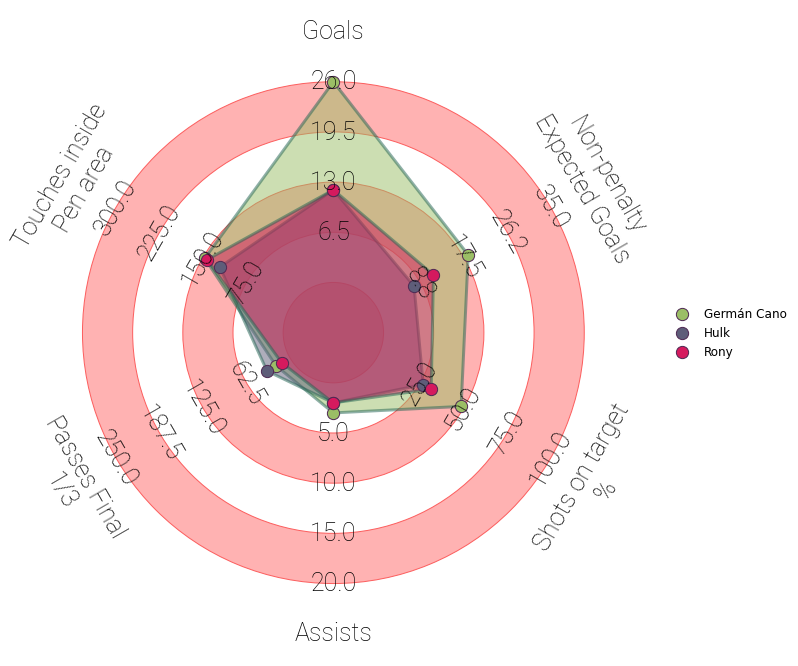

In [62]:
params = ["Goals", "Non-penalty Expected Goals", "Shots on target %", "Assists", "Passes Final 1/3", "Touches inside Pen area"]
players = []

cano = Player('Germán Cano', 'fw')
hulk = Player('Hulk', 'fw')
rony = Player('Rony', 'fw')

players.append(cano)
players.append(hulk)
players.append(rony)

low = np.zeros(6)
high = [26.0, 35.0, 100.0, 20, 250, 300]

plot_radar(params, players, low, high)

## Questão 4
- Faça o mesmo que na questão 3, mas para meio campistas.

In [81]:
# Rafael Veiga, Arrasca, André (Fluminense)
# Incluir caracter[istica defensiva

params = ["Goals", "Assists", "Passes Final 1/3", "Succesful Dribbles/take-ons", "Ball Recoveries", "Interceptions"]
players = []

veiga = Player('Raphael Veiga', 'mf')
arrascaeta = Player('Giorgian De Arrascaeta', 'mf')
andre = Player('André', 'mf')

players.append(veiga)
players.append(arrascaeta)
players.append(andre)

low = np.zeros(6)
high = [26.0, 15, 100.0, 50, 250, 300]
plot_radar(params, players, low, high)

TypeError: cannot convert the series to <class 'float'>

## Questão 5
- Faça o mesmo que na questão 3, mas para zagueiros.

In [ ]:
# faltas (lower is better)
# TODO: function to load batabases
params = ["Blocked passes", "Interceptions", "% of dribblers tackled", "Aerial duels win %", "Ball Recoveries", "Fouls"]
players = []



## Questão 6
- Discuta as diferenças entre os radares das questões 3, 4 e 5. Quais são as principais diferenças entre os atributos relevantes para cada posição? Quais são as principais semelhanças? A impressão subjetiva que você tinha dos jogadores se comprovou pelos radares? Se não, por quê? Quais posições são mais difíceis de serem avaliadas por estatísticas?